# Лабораторная работа №8 по вычислительной математике
## Применение метода стрельбы для решения ДУ.
### Выполнил Филиппенко Павел -- студент группы Б01-009

##### Задание XI.9.2 (б)

In [52]:
import numpy as np
import matplotlib.pyplot as plt

#### Методология

Опишем методологию метода стрельбы. Будем решать краевую задачу вида

$$
\begin{cases}
y'' = f(x, y, y') \\
y(0) = y_0 \\
y(L) = y_1
\end{cases}
$$

Для решение данной краевой задачи, рассмотрим вспомогательную задачу

$$
\begin{cases}
y'' = f(x, y, y') \\
y(0) = y_0 \\
y'(0) = \alpha
\end{cases}
$$

где $\alpha$ -- некоторое число, называемое _пристрелочным параметром_. Для численного решения 
полученной задачи Коши, понизим порядок системы.

$$
\begin{cases}
u' = f(x, y, u) \\
y' = u \\
y(0) = y_0 \\
u(0) = \alpha
\end{cases}
$$

Решая данную численную задачу одим, из известных нам методов (например, методами Рунге-Куты), мы получим
численное решение $y(x, \alpha)$. Возвращаясь к изначальной задаче и рассматривая условие на правой 
границе (в точке $L$), получим уравнение

$$
F(\alpha) = y(x, \alpha) - y_1 = 0
$$

Все, что нам остается -- подобрать такой параметр $\alpha$, чтобы данное выражение превратилось в 
тождество, иначе, решить данное, в общем случае, нелинейное уравнение.

#### Подбор пристрелочного параметра

Поскольку уравнение $F(\alpha) = y(x, \alpha) - y_1 = 0$ в общем случае является нелинейным, можно
попробовать применить к нему метод Ньютона решения нелинейных уравнений

$$
\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{F'(\alpha_n)}
$$

Проблема состоит в том, что, в данном случае, уравнение $F(\alpha) = 0$ задано не аналитическим 
выражением, а, как бы, расчетным методом. Решить данную проблему можно следующим образом: вернемся к 
вспомогательной задаче

$$
\begin{cases}
u' = f(x, y, u) \\
y' = u \\
y(0) = y_0 \\
u(0) = \alpha
\end{cases}
$$

и продифференцируем ее по $\alpha$. 

$$
\begin{cases}
\frac{d}{dx} \left(\frac{\partial u}{\partial \alpha} \right) = \frac{\partial f}{\partial y} \frac{\partial y}{\partial \alpha} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial \alpha} \\ 
\frac{d}{dx} \left(\frac{\partial y}{\partial \alpha} \right) = \frac{\partial u}{\partial \alpha} \\
\frac{\partial y}{\partial \alpha}(0) = 0 \\
\frac{\partial u}{\partial \alpha}(0) = 1
\end{cases}
$$

Для удобства восприятия сделаем замену: 

$$
\frac{\partial y}{\partial \alpha} = A \\ 
\frac{\partial u}{\partial \alpha} = B
$$

тогда перепишем последнюю систему

$$
\begin{cases}
\frac{dB}{dx} = A \frac{\partial f}{\partial y} + B \frac{\partial f}{\partial u} \\ 
\frac{dA}{dx} = B \\
A(0) = 0 \\
B(0) = 1
\end{cases}
$$

Решая численно данную систему относительно $A$ и $B$ (решаем обычную численную задачу, например методами Рунге-Куты), получим $A = \frac{\partial y}{\partial \alpha}$.
Тогда, мы уже сможем воспользоваться методом Ньютона:

$$
\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{\frac{\partial y}{\partial \alpha}(\alpha_n)}
$$

#### Алгоритм решения задачи

- Выбираем начальный пристрелочный параметр $\alpha_0$
- Решаем вспомогательную задачу Коши, получаем $F(\alpha_0)$ (это число)
- Решаем продифференцированную вспомогательную задачу Коши, получаем $\frac{\partial y}{\partial \alpha}(\alpha_0)$ (это тоже число)
- С помощью итерации метода Ньютона получаем новое $\alpha$ : $\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{\frac{\partial y}{\partial \alpha}(\alpha_n)}$
- Повторяем этот алгоритм до тех пор, пока не выполнится условие $|F(\alpha_n)| < \varepsilon$, где $\varepsilon$ -- заранее заданная точность.

#### Целевая задача

Будем решать следующую задачу
$$
\begin{cases}
y'' = \frac{(y')^2}{y - 2} \\
y(0) = y_0 \\
y(1) = 0
\end{cases}
$$

Понизим порядок системы для численного решения
$$
\begin{cases}
u' = \frac{u^2}{y - 2} \\
y' = u \\
y(0) = y_0 \\
y(1) = 0
\end{cases}
$$

In [53]:
# Задаем функции правой части
def f1(y, u):
    return u**2 / (y - 2)

def f2(y, u):
    return u

def F(t, y_vec):
    y = y_vec[0]
    u = y_vec[1]
    return np.array([
        f2(y, u),
        f1(y, u)
    ])

In [54]:
# Метод Рунге-Кутты 4 порядка
# Реализация для решения системы двух уравнений первого порядка (initial_solution -- вектор из 2 значений)
def MRK4(f, h, t_start, t_end, initial_solution):
    t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))
    # the system dimention is 2
    solution = np.zeros((int((t_end-t_start)/h+1), 2))
    solution[0] = initial_solution

    for i in range(len(t) - 1):
        k1 = f(t[i], solution[i])
        k2 = f(t[i] + h/2, solution[i] + h*k1 * 0.5)
        k3 = f(t[i] + h/2, solution[i] + h*k2 * 0.5)
        k4 = f(t[i] + h, solution[i] + h*k3)
        solution[i+1] = solution[i] + h*(k1 + 2*k2 + 2*k3 + k4) / 6
    return solution

##### Неочевидны момент

При теоретическом разборе метода стрельбы с поиском пристрелоного параметра методом Ньютона не 
совсем очевидно, в какой момент и каким образом решается вторая вспомогательная система

$$
\begin{cases}
\frac{dB}{dx} = A \frac{\partial f}{\partial y} + B \frac{\partial f}{\partial u} \\ 
\frac{dA}{dx} = B \\
A(0) = 0 \\
B(0) = 1
\end{cases}
$$

Дело в том, что система решается относительно $A$ и $B$. Между тем, в составе системы присутствуют
частные производные функции $f$. При написании численного алгоритма, мы не только не знаем численные
значения этих производных, но даже не понимаем, в каких точках нужно их брать.

На самом деле, данную вспомогательную систему нужно решать одновременно с первой вспомогательной 
системой. Для этого, нам даже придется переписать метод Рунге-Кутты. Если коротко, в каждой точке
$x$ сетки, мы сначала вычисляем значения частных производных $f$ (их можно найти аналитически и 
затем подставить значения), составляем функцию правой части для второй вспомогательной системы
и вычисляем значения $A(x)$ и $B(x)$ в следующей точке $x$ сетки.

__Note:__ если вы ничего не поняли, смотрите код функции _ModMRK4_ ~~или обратитесь к автору решения~~.

In [55]:
# Модифицированный метод Рунге-Кутты
# Помимо решения основной задачи Коши, параллельно так же решает вспомогательную систему ДУ
# для нахождения частной производной функци f по пристрелочному параметру alpha
# Функция возвращает кортеж из двух объектов:
# вектор решений основной системы
# значение производной функции f по пристрелочному параметру в крайней правой точке
def ModMRK4(f, h, x_start, x_end, initial_solution):
    x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
    # the system dimention is 2
    solution = np.zeros((int((x_end-x_start)/h+1), 2))
    solution[0] = initial_solution

    ab_init_sol = np.array([0, 1])
    ab_solution = np.zeros((int((x_end-x_start)/h+1), 2))
    ab_solution[0] = ab_init_sol

    for i in range(len(x) - 1):
        k1 = f(x[i], solution[i])
        k2 = f(x[i] + h/2, solution[i] + h*k1 * 0.5)
        k3 = f(x[i] + h/2, solution[i] + h*k2 * 0.5)
        k4 = f(x[i] + h, solution[i] + h*k3)
        solution[i+1] = solution[i] + h*(k1 + 2*k2 + 2*k3 + k4) / 6

        yi, ui = solution[i]
        df_dy = (-ui**2)/(yi - 2)**2
        df_du = 2*ui / (yi - 2)

        def g1(A, B):
            return A*df_dy + B*df_du

        def g2(A, B):
            return B

        def G(x, ab_vec):
            A = ab_vec[0]
            B = ab_vec[1]
            return np.array([
                g2(A, B),
                g1(A, B)
            ])
        
        ab_k1 = G(x[i], ab_solution[i])
        ab_k2 = G(x[i] + h/2, ab_solution[i] + h*ab_k1 * 0.5)
        ab_k3 = G(x[i] + h/2, ab_solution[i] + h*ab_k2 * 0.5)
        ab_k4 = G(x[i] + h,   ab_solution[i] + h*ab_k3)
        ab_solution[i+1] = ab_solution[i] + h*(ab_k1 + 2*ab_k2 + 2*ab_k3 + ab_k4) / 6
    
    A, B = ab_solution.T
    return (solution, A[-1])

##### Бинарный поиск

Кроме использования метода Ньютона для нахождения пристрелочного параметра можно так же 
использовать метод бинарного поиска (дешево и сердито). Бинарный поиск можно использовать и в
других целях. Как мы знаем, метод Ньютона требует начальное значени параметра, если начальное 
значение задано плохо, метод может разойтись. Таким образом, бинарный поиск можно использовать для 
первичной локализации значения пристрелочного параметра (Задаем границы бинпоиска и не не очень
большую тоность решения). 

In [56]:
# alpha_left и alpha_right -- начальные границы диапазона, в котором происходит бин поиск
# eps -- точность решения
# Остальные аргументы функции такие же, как для метода Рунге-Куты
def BinaryFindOut(alpha_left, alpha_right, eps, f, h, t_start, t_end, y0):
    init_solution = np.array([y0, alpha_right])
    sol = MRK4(f, h, t_start, t_end, init_solution)
    y, u = sol.T
    y_L = y[-1]

    alpha = 0
    while (abs(y_L) > eps):
        alpha = (alpha_left+alpha_right)/2
        init_sol = np.array([y0, alpha])
        sol = MRK4(f, h, t_start, t_end, init_sol)
        y, u = sol.T

        assert(abs(y[0] - y0) < eps)
        assert(abs(u[0] - alpha) < eps)
        y_L = y[-1]
        if (y_L < 0):
            alpha_left = alpha
        else:
            alpha_right = alpha
    
    return y, u, alpha

In [57]:
# initial_alpha -- начальное значение, от которого будет работать метод Ньютона (можно уточнить с помощью бин поиска)
# eps -- точность решения
# Остальные аргументы функции такие же, как для метода Рунге-Куты
def SootingMthd(initial_alpha, eps, f, h, t_start, t_end, y0):
    init_sol = np.array([y0, initial_alpha])

    res = ModMRK4(F, h, t_start, t_end, init_sol)
    sol = res[0]
    y, u = sol.T

    df_dal = res[1]
    y_L = y[-1]

    alpha_prev = alpha_next = initial_alpha
    while (abs(y_L) > eps):
        alpha_prev = alpha_next
        alpha_next = alpha_prev - y_L/df_dal

        init_sol = np.array([y0, alpha_next])
        res = ModMRK4(F, h, t_start, t_end, init_sol)
        sol = res[0]
        y, u = sol.T

        df_dal = res[1]
        y_L = y[-1]
    
    return y, alpha_next

In [58]:
# зададим параметры задачи
x_start = 0
x_end   = 1
h = 0.01
y0 = 1.95

# список различных граничных значений
y0_list = [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95]

# точность решения
eps = 1e-6

Найдем значение пристрелочного параметра и решение задачи с помощью бин поиска.

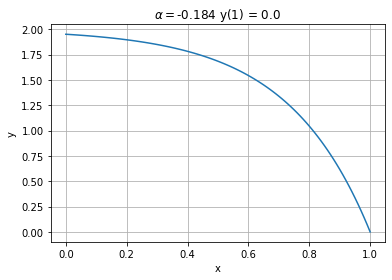

In [59]:
# применяем метод бинарного поиска
alpha_left = -1
alpha_right = 1

y, u, alpha = BinaryFindOut(alpha_left, alpha_right, eps, F, h, x_start, x_end, y0)

x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
plt.plot(x, y)
plt.title(r'$\alpha = $' + f'{round(alpha, 3)} ' + f'y(1) = {round(y[-1], 3)}')
plt.ylabel('y')
plt.xlabel('x')
plt.grid()

Найдем значение пристрелочного параметра и решение задачи с помощью метода стрельбы с использованием
решения второй вспомогательной системы.

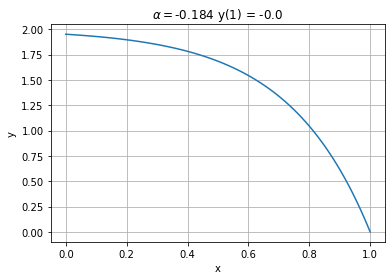

In [60]:
initial_alpha = -1
y, alpha = SootingMthd(initial_alpha, eps, F, h, x_start, x_end, y0)

x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
plt.plot(x, y)
plt.title(r'$\alpha = $' + f'{round(alpha, 3)} ' + f'y(1) = {round(y[-1], 3)}')
plt.ylabel('y')
plt.xlabel('x')
plt.grid()

Рассмотрим решение задачи с различными граничными условиями.

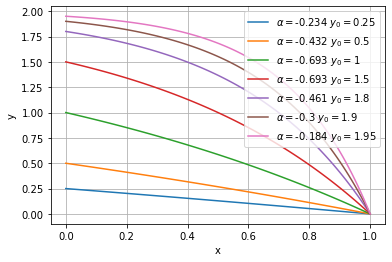

In [61]:
for y0 in y0_list:
    y, alpha = SootingMthd(initial_alpha, eps, F, h, x_start, x_end, y0)

    x = np.linspace(x_start, x_end, int((x_end-x_start)/h+1))
    plt.plot(x, y, label=r'$\alpha = $' + f'{round(alpha, 3)}' + r' $y_0 = $' + f'{y0}')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend()
    plt.grid()

#### Вывод

Как видно, при подборе пристрелочного параметра метод Ньютона и бинарный поиск приводят к 
правильному ответу. Есть предположение, что метод Ньютона сходится к правильному ответу быстрее, 
однако, данный вопрос не исследовался. При этом, Реализация метода Ньютона неочевидна, требует 
переписывания функции решения ДУ и может разойтись при плохо заданном начальном условии.